# Bank of England Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from matplotlib.ticker import FuncFormatter
import statsmodels.api as sm
from scipy.stats import linregress
import requests
import io
from pathlib import Path

In [2]:
def get_boe_data(
    name: str,
    codes: str,
    start_date: str,
    end_date: str = "",
) -> pd.DataFrame:
    """Return DataFrame with requested BoE data."""

    today = date.today()
    filename = name + "_" + today.strftime("%Y%m%d") + ".pkl"

    if Path(filename).is_file():  # already fetched
        return pd.read_pickle(filename)

    url_endpoint = (
        "http://www.bankofengland.co.uk/boeapps/iadb/fromshowcolumns.asp?csv.x=yes"
    )

    if end_date == "":
        end_date = today.strftime("%d/%b/%Y")

    params = {
        "Datefrom": start_date,
        "Dateto": end_date,
        "SeriesCodes": codes,
        "CSVF": "TN",
        "UsingCodes": "Y",
        "VPD": "Y",
        "VFD": "N",
    }

    headers = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/54.0.2840.90 "
        "Safari/537.36"
    }

    response = requests.get(url_endpoint, params=params, headers=headers)
    print(response.status_code)
    # print(response.url)
    # print(response.content)
    df_boe = pd.read_csv(io.BytesIO(response.content))
    df_boe["DATE"] = pd.to_datetime(df_boe["DATE"], format="%d %b %Y")
    df_boe.to_pickle(filename)
    return df_boe

In [3]:
def get_ons_data(name: str = "cpih"):
    """Return DataFrame with requested ONS data.

    Currently hard coded for CPIH.
    """

    today = date.today()
    filename = name + "_" + today.strftime("%Y%m%d") + ".pkl"

    if Path(filename).is_file():  # already fetched
        return pd.read_pickle(filename)

    url = "https://api.beta.ons.gov.uk/v1/datasets/cpih01/editions/time-series/versions/52/observations"
    params = {
        "time": "*",
        "geography": "K02000001",
        "aggregate": "CP00",
    }

    response = requests.get(url, params=params)
    print("Status Code:", response.status_code)
    # print("URL Requested:", response.url)

    results = response.json()
    # print(results)
    summary = []
    for observation in results.get("observations"):
        ident = observation.get("dimensions").get("Time").get("id")
        summary.append({"id": ident, "observation": observation.get("observation")})
    df_ons = pd.DataFrame(summary)

    # hard set for CPIH
    df_ons.columns = ["Date", "CPIH"]
    df_ons["Date"] = pd.to_datetime(df_ons["Date"], format="%b-%y")
    df_ons["CPIH"] = df_ons["CPIH"].astype("float64")
    df_ons.to_pickle(filename)
    return df_ons

## Mortgages

In [4]:
df_mort = get_boe_data("mortgages", "LPMB3C2,LPMVTVU", "01/Jan/2000")
df_mort.columns = ["Date", "Total", "Number"]
df_mort["Average"] = df_mort["Total"] / df_mort["Number"] * 1000000
df_mort = df_mort.sort_values(by="Date")
df_mort["Month_Year"] = df_mort["Date"].dt.strftime("%b %y")
last_date = df_mort["Date"].max().strftime("%d %b %y")
df_mort

,Date,Total,Number,Average,Month_Year
0,2000-01-31,2859,50816,56261.807305,Jan 00
1,2000-02-29,4605,87861,52412.333117,Feb 00
2,2000-03-31,6176,118265,52221.705492,Mar 00
3,2000-04-30,5132,99600,51526.104418,Apr 00
4,2000-05-31,5748,110890,51835.151952,May 00
...,...,...,...,...,...
293,2024-06-30,15571,66625,233711.069418,Jun 24
294,2024-07-31,17148,73174,234345.532566,Jul 24
295,2024-08-31,15748,66939,235258.967119,Aug 24
296,2024-09-30,15289,65048,235041.815275,Sep 24


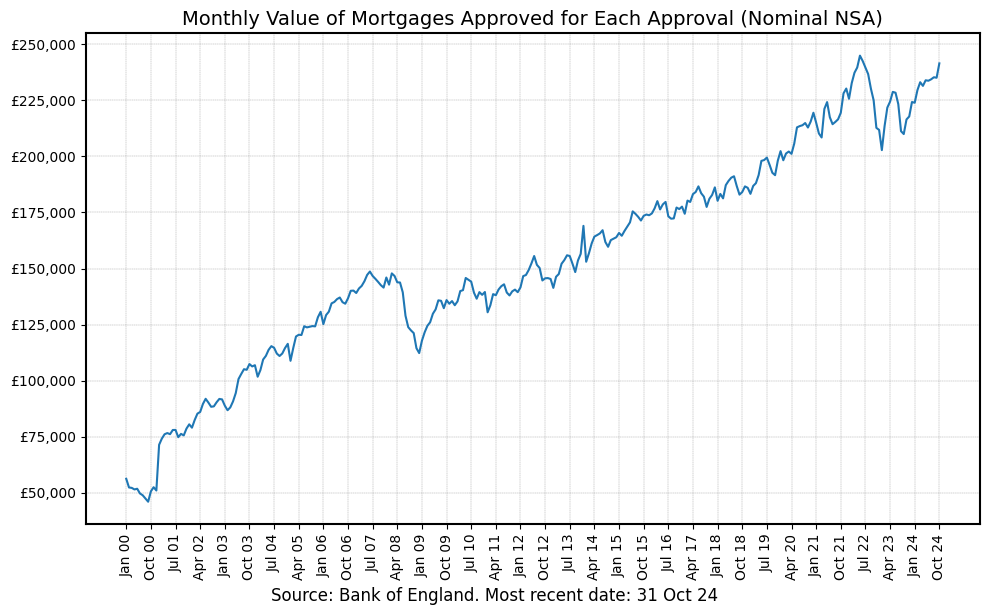

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_facecolor("white")

ax.plot(df_mort["Month_Year"], df_mort["Average"])

ax.set_title(
    "Monthly Value of Mortgages Approved for Each Approval (Nominal NSA)", fontsize=14
)

formatter = FuncFormatter(lambda x, pos: f"£{x:,.0f}")
plt.gca().yaxis.set_major_formatter(formatter)
ax.grid(True, color="grey", linestyle="--", linewidth=0.25)

xticks = df_mort["Month_Year"][::9]  # every nth date
plt.xticks(xticks, rotation=90)

for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

fig.text(
    0.5,
    -0.01,
    f"Source: Bank of England. Most recent date: {last_date}",
    ha="center",
    fontsize=12,
    color="black",
)

plt.tight_layout()

plt.savefig("mortgages.png", dpi=300, bbox_inches="tight")

## Nominal Savings

In [6]:
df_nsav = get_boe_data(
    "savings", "LPMB8S4,LPMVYWO,LPMZOD3,LPMZOD4,LPMZOD5", "01/Jan/2011"
)
names = ["ISA", "Cash", "No_Interest", "Interest", "Time"]
df_nsav.columns = ["Date"] + names
df_nsav["Total"] = df_nsav[names].sum(axis=1)  # * 1000000
df_nsav = df_nsav.sort_values(by="Date")
df_nsav["Month_Year"] = df_nsav["Date"].dt.strftime("%b %y")
last_date = df_nsav["Date"].max().strftime("%d %b %y")
df_nsav

,Date,ISA,Cash,No_Interest,Interest,Time,Total,Month_Year
0,2011-01-31,175179,47013,97247,414080,259468,992987,Jan 11
1,2011-02-28,177529,47129,99135,412541,261288,997622,Feb 11
2,2011-03-31,180961,47165,100044,412333,262557,1003060,Mar 11
3,2011-04-30,188228,48471,100494,410941,262294,1010428,Apr 11
4,2011-05-31,190484,47857,98143,404324,263109,1003917,May 11
...,...,...,...,...,...,...,...,...
161,2024-06-30,370003,78746,232499,884780,248963,1814991,Jun 24
162,2024-07-31,372997,78691,227445,883163,248780,1811076,Jul 24
163,2024-08-31,376028,78689,230637,889826,248499,1823679,Aug 24
164,2024-09-30,379150,78660,230701,894045,248940,1831496,Sep 24


In [7]:
# Add pre-covid linear regression
start_date = "2011-01-01"
end_date = "2020-03-01"

# Filter data for the regression fit
fit_data = df_nsav[(df_nsav["Date"] >= start_date) & (df_nsav["Date"] <= end_date)]

# Convert dates to numeric format for regression (e.g., as days since the first date)
df_nsav["days"] = (df_nsav["Date"] - df_nsav["Date"].min()).dt.days
fit_data = df_nsav[
    (df_nsav["Date"] >= start_date) & (df_nsav["Date"] <= end_date)
].copy()

# Fit linear regression
slope, intercept, rvalue, _, _ = linregress(fit_data["days"], fit_data["Total"])

# Calculate R-squared
precovid_r_squared = rvalue**2

# Project regression line over the full date range
df_nsav["pre-covid"] = intercept + slope * df_nsav["days"]

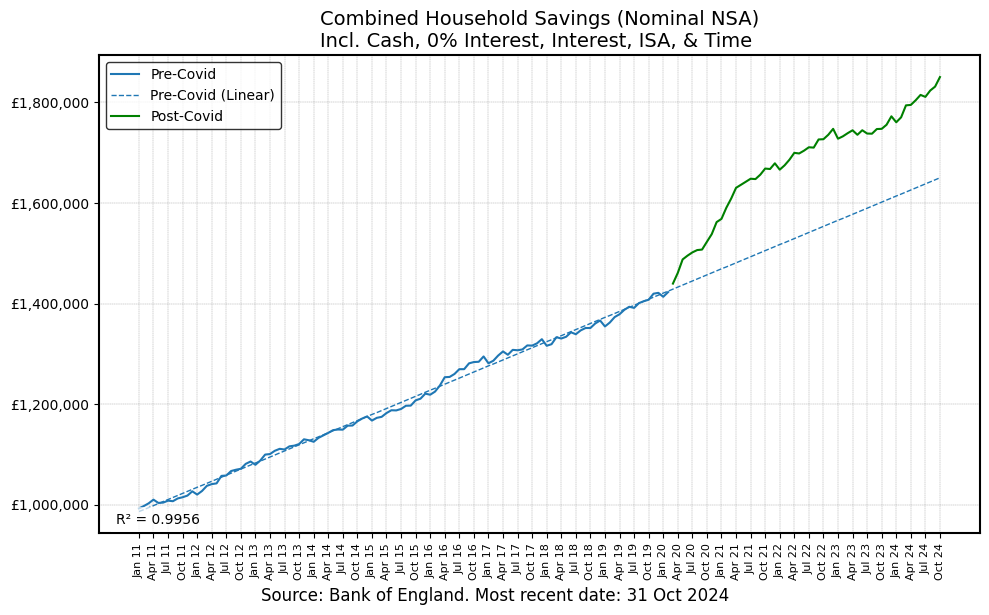

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor("white")

# Split the data into two parts based on the dates
df_nsav_precovid = df_nsav[df_nsav["Date"] <= end_date]
df_nsav_postcovid = df_nsav[df_nsav["Date"] > end_date]

# Pre-covid
(line1,) = ax.plot(
    df_nsav_precovid["Month_Year"], df_nsav_precovid["Total"], label="Pre-Covid"
)
color = line1.get_color()

ax.plot(
    df_nsav["Month_Year"],
    df_nsav["pre-covid"],
    label="Pre-Covid (Linear)",
    color=color,
    linestyle="--",
    linewidth=1,
)

# Post-covid
ax.plot(
    df_nsav_postcovid["Month_Year"],
    df_nsav_postcovid["Total"],
    color="green",
    label="Post-Covid",
)

ax.set_title(
    "Combined Household Savings (Nominal NSA)\nIncl. Cash, 0% Interest, Interest, ISA, & Time ",
    fontsize=14,
)

formatter = FuncFormatter(lambda x, pos: f"£{x:,.0f}")
plt.gca().yaxis.set_major_formatter(formatter)
ax.grid(True, color="grey", linestyle="--", linewidth=0.25)

xticks = df_nsav["Month_Year"][::3]  # every nth date
plt.xticks(xticks, rotation=90)
plt.tick_params(axis="x", labelsize=8)

# Set the spines (borders) to black
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

fig.text(
    0.5,
    -0.01,
    "Source: Bank of England. Most recent date: 31 Oct 2024",
    ha="center",
    fontsize=12,
    color="black",
)

# Add R-squared as a note in the bottom-left corner
plt.text(
    0.02,
    0.02,  # Position: 2% from the bottom-left
    f"R² = {precovid_r_squared:.4f}",
    transform=plt.gca().transAxes,  # (0,0 is bottom-left)
    fontsize=10,
    color="black",
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
)

plt.legend(facecolor="white", edgecolor="black", fontsize=10)
plt.tight_layout()

plt.savefig("savings_nominal.png", dpi=300, bbox_inches="tight")

## Get CPI Data

In [9]:
df_cpi = get_ons_data("cpih")
df_cpi["Month_Year"] = df_cpi["Date"].dt.strftime("%b %y")
df_cpi = df_cpi.sort_values(by="Date")

## Real Savings

In [10]:
df_rsav = df_nsav.merge(df_cpi[["Month_Year", "CPIH"]], on="Month_Year", how="left")
df_rsav["Real_Total"] = df_rsav["Total"] / df_rsav["CPIH"]
df_rsav["Real_Total"] = df_rsav["Real_Total"].astype("float64")

new_date = "2023-09-01"

# Pre-covid
fit_data = df_rsav[(df_rsav["Date"] >= start_date) & (df_rsav["Date"] <= end_date)]
precovid_slope, precovid_intercept, rvalue, _, _ = linregress(
    fit_data["days"], fit_data["Real_Total"]
)
precovid_r_squared = rvalue**2
df_rsav["pre-covid-real"] = precovid_intercept + precovid_slope * df_rsav["days"]

# New normal
fit_data = df_rsav[(df_rsav["Date"] >= new_date)]
new_slope, new_intercept, rvalue, _, _ = linregress(
    fit_data["days"], fit_data["Real_Total"]
)
new_r_squared = rvalue**2
df_rsav["new-real"] = new_intercept + new_slope * df_rsav["days"]

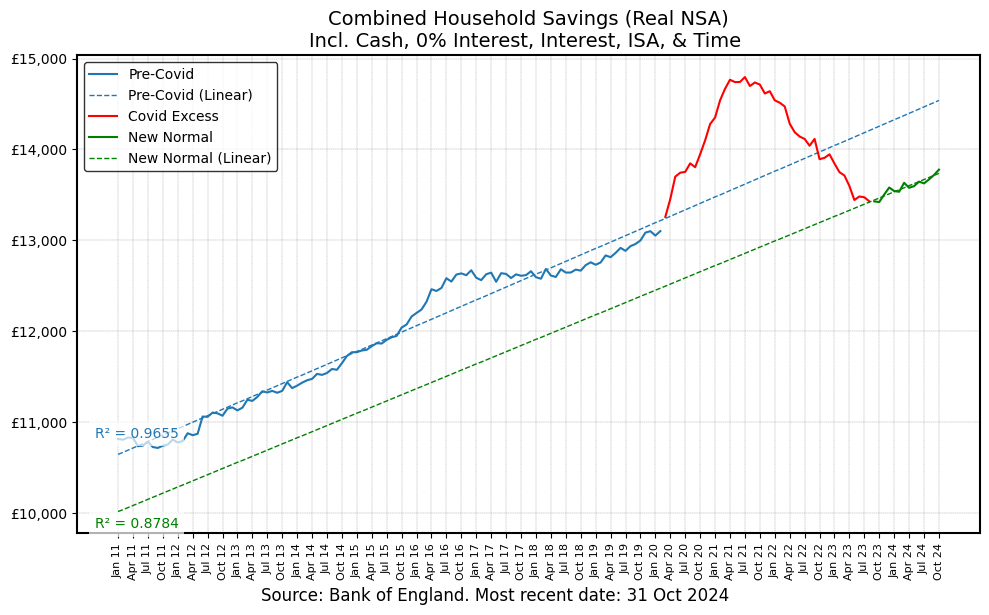

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor("white")

# Split the data based on the date
df_precovid = df_rsav[df_rsav["Date"] <= end_date]
df_covid = df_rsav[df_rsav["Date"] >= end_date]
df_new = df_covid[df_covid["Date"] >= new_date]
df_covid = df_covid[df_covid["Date"] <= new_date]

# Pre-covid
(line1,) = ax.plot(
    df_precovid["Month_Year"], df_precovid["Real_Total"], label="Pre-Covid"
)
color = line1.get_color()

ax.plot(
    df_rsav["Month_Year"],
    df_rsav["pre-covid-real"],
    label="Pre-Covid (Linear)",
    color=color,
    linestyle="--",
    linewidth=1,
)

# covid excess
ax.plot(
    df_covid["Month_Year"], df_covid["Real_Total"], color="red", label="Covid Excess"
)

# new normal
ax.plot(df_new["Month_Year"], df_new["Real_Total"], color="green", label="New Normal")

ax.plot(
    df_rsav["Month_Year"],
    df_rsav["new-real"],
    label="New Normal (Linear)",
    color="green",
    linestyle="--",
    linewidth=1,
)

ax.set_title(
    "Combined Household Savings (Real NSA)\nIncl. Cash, 0% Interest, Interest, ISA, & Time ",
    fontsize=14,
)

formatter = FuncFormatter(lambda x, pos: f"£{x:,.0f}")
plt.gca().yaxis.set_major_formatter(formatter)
ax.grid(True, color="grey", linestyle="--", linewidth=0.25)

xticks = df_rsav["Month_Year"][::3]  # every nth date
plt.xticks(xticks, rotation=90)
plt.tick_params(axis="x", labelsize=8)

# Set the spines (borders) to black
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

fig.text(
    0.5,
    -0.01,
    "Source: Bank of England. Most recent date: 31 Oct 2024",
    ha="center",
    fontsize=12,
    color="black",
)

# Add Pre-covid R-squared as a note in the bottom-left corner
plt.text(
    0.02,
    0.2,  # Position: 2% from the bottom-left
    f"R² = {precovid_r_squared:.4f}",
    transform=plt.gca().transAxes,  # (0,0 is bottom-left)
    fontsize=10,
    color=color,
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
)
# Add New normal R-squared as a note in the bottom-left corner
plt.text(
    0.02,
    0.01,  # Position: 2% from the bottom-left
    f"R² = {new_r_squared:.4f}",
    transform=plt.gca().transAxes,  # (0,0 is bottom-left)
    fontsize=10,
    color="green",
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
)
plt.legend(facecolor="white", edgecolor="black", fontsize=10)
plt.tight_layout()

plt.savefig("savings_real.png", dpi=300, bbox_inches="tight")

### No statistically significant difference in growth between before and after

In [12]:
# Combine pre-COVID and New Normal data
df_new["Period"] = "New Normal"
df_combined = pd.concat([df_precovid, df_new])

# Encode the period as a binary variable
df_combined["Period_Binary"] = (df_combined["Period"] == "New Normal").astype(int)

# Define the independent variable (i.e., Date) and dependent variable
X = sm.add_constant(
    pd.DataFrame(
        {
            "Time": df_combined["Date"].factorize()[
                0
            ],  # Numeric representation of dates
            "Period_Binary": df_combined["Period_Binary"],
            "Interaction": df_combined["Date"].factorize()[0]
            * df_combined["Period_Binary"],
        }
    )
)
y = df_combined["Real_Total"]

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Real_Total   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1728.
Date:                Sat, 07 Dec 2024   Prob (F-statistic):           1.65e-98
Time:                        22:47:04   Log-Likelihood:                -783.15
No. Observations:                 124   AIC:                             1574.
Df Residuals:                     120   BIC:                             1586.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.065e+04     25.773    413.098